#### 1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [5]:
# Добавлен коэффициент b0 в алгоритм предсказывания

def gb_predict(X, trees_list, coef_list, eta, b0=0):
    return np.array([sum([b0 + eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [7]:
def bias(y, z):
    return (y - z)

##### b0_start - режим вычислений b0
- 'mean' - среднее по выборке y_train
- 'zero' - инициализация нулём

In [8]:
# Добавлен b0. 

def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, b0_start='zero'):
    
    b0 = 0
    
    if b0_start != 'zero':
        b0 = np.mean(y_train)
       
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    
        target = gb_predict(X_train, trees, coefs, eta, b0)
        tree.fit(X_train, bias(y_train, target))
        train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
        test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [9]:
# Число деревьев в ансамбле
n_trees_start = 10
n_trees = []

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees_start

# Максимальная глубина деревьев
max_depth_start = 1
max_depth = []

# Шаг
eta = 1

# Начальный алгоритм. Режимы работы описаны перед инициализацией gb_fit
b0_mode = 'zero'

train_error_list = []
test_error_list = []

while n_trees_start < 30:
    coefs = [1] * n_trees_start
    trees, train_errors, test_errors = gb_fit(n_trees_start, max_depth_start, X_train, X_test, y_train, y_test, coefs, eta, b0_mode)
    train_error_list.append(np.mean(train_errors))
    test_error_list.append(np.mean(test_errors))
    n_trees.append(n_trees_start)
    max_depth.append(max_depth_start)
    max_depth_start += 1
    n_trees_start += 5

In [10]:
import matplotlib.pyplot as plt

In [11]:
def get_error_trees_plot(n_trees, train_err, test_err):
    plt.xlabel('Number of trees')
    plt.ylabel("Error's value")
    plt.plot(n_trees, train_err, label='train error')
    plt.plot(n_trees,  test_err, label='test error')
    
    plt.legend(loc='upper right')
    plt.show()

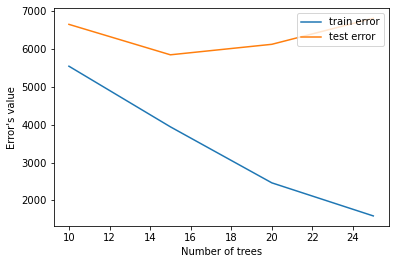

In [12]:
get_error_trees_plot(n_trees, train_error_list, test_error_list)

In [13]:
def get_error_depth_plot(max_depth, train_err, test_err):
    plt.xlabel("Depth")
    plt.ylabel("Error's value")
    plt.plot(max_depth, train_err, label='train error')
    plt.plot(max_depth, test_err, label='test error')
    
    plt.legend(loc='upper right')
    plt.show()

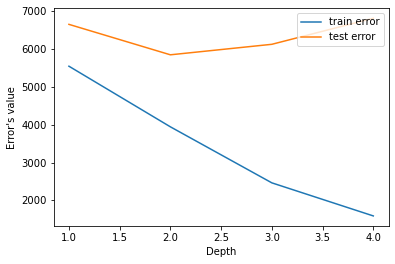

In [14]:
get_error_depth_plot(max_depth, train_error_list, test_error_list)

##### Вывод: исходя из графиков можно сказать, что при увеличении глубины и числа деревьев возможно наступление переобучения.

#### 2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [79]:
# Добавление регуляризации
# Добавлен коэффициент b0 в алгоритм предсказывания

def sgb_predict(X, trees_list, coef_list, eta, b0=0, lambda_=1e-8):
    return np.array([sum([lambda_ * np.sign(coef) + b0 + eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [80]:
def sgb_fit(iterations, max_depth, X, y, coefs, eta, b0_start='zero'):
    
    b0 = 0
    
    if b0_start != 'zero':
        b0 = np.mean(y_train)
       
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(iterations):
        
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.50)
        
        target = sgb_predict(X_train, trees, coefs, eta, b0)
        tree.fit(X_train, bias(y_train, target))
        train_errors.append(mean_squared_error(y_train, sgb_predict(X_train, trees, coefs, eta)))
        test_errors.append(mean_squared_error(y_test, sgb_predict(X_test, trees, coefs, eta)))
        
        trees.append(tree)
        
    return trees, train_errors, test_errors

In [81]:
# Число деревьев в ансамбле
iterations = 10


# для простоты примем коэффициенты равными 1
coefs = [1] * iterations

# Максимальная глубина деревьев
max_depth_start = 3

# Шаг
eta = 1

# Начальный алгоритм. Режимы работы описаны перед инициализацией gb_fit
b0_mode = 'zero'

train_error_list = []
test_error_list = []

while iterations < 100:
    coefs = [1] * iterations
    trees, train_errors, test_errors = sgb_fit(iterations, max_depth_start, X_train, y_train, coefs, eta, b0_mode)
    train_error_list.append(np.mean(train_errors))
    test_error_list.append(np.mean(test_errors))
    print(train_error_list)
    print(test_error_list)
    
    iterations += 10

[5649.6822583075]
[5763.371778290531]
[5649.6822583075, 3939.844929446407]
[5763.371778290531, 4166.304679982304]
[5649.6822583075, 3939.844929446407, 3438.2294144457364]
[5763.371778290531, 4166.304679982304, 3334.212207728982]
[5649.6822583075, 3939.844929446407, 3438.2294144457364, 2979.9984340016094]
[5763.371778290531, 4166.304679982304, 3334.212207728982, 2943.6860148008936]
[5649.6822583075, 3939.844929446407, 3438.2294144457364, 2979.9984340016094, 3340.5990289869333]
[5763.371778290531, 4166.304679982304, 3334.212207728982, 2943.6860148008936, 3412.8458806537733]
[5649.6822583075, 3939.844929446407, 3438.2294144457364, 2979.9984340016094, 3340.5990289869333, 2262.603190590214]
[5763.371778290531, 4166.304679982304, 3334.212207728982, 2943.6860148008936, 3412.8458806537733, 2244.956104328199]
[5649.6822583075, 3939.844929446407, 3438.2294144457364, 2979.9984340016094, 3340.5990289869333, 2262.603190590214, 2844.236891484794]
[5763.371778290531, 4166.304679982304, 3334.212207728

In [82]:
def get_error_iterations_plot(iterations, train_err, test_err):
    plt.xlabel("Iteration's value")
    plt.ylabel("Error's value")
    plt.plot(iterations, train_err, label='train error')
    plt.plot(iterations, test_err, label='test error')
    
    plt.legend(loc='upper right')
    plt.show()

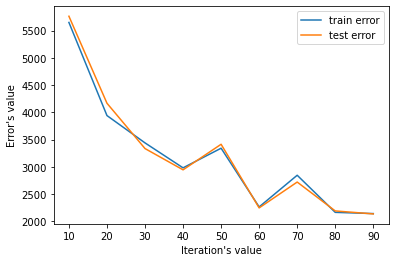

In [85]:
iterations = []
for i in range(1, 10):
    iterations.append(i * 10)
get_error_iterations_plot(iterations, train_error_list, test_error_list)